 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 9. CNN Basis**
# Section 6. High API를 이용한 CNN 모델 구성하기

### _Objective_
1. Low-API로는 다양한 tuning이 가능하지만, 코드가 지나치게 길어집니다. <br>
1. High-API를 이용해 코드를 간결하게 만들고, 코드를 개선하도록 하겠습니다. <br> 
  
╚══════════════════════════════════════════╝

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tqdm import tqdm

## Graph Visualization

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

<br><br>

# \[ 1. High-API를 통한 코드의 간결화 \]

----
----
 
> *텐서플로우는 Low-API부터 High-API까지 다양하게 지원합니다.*<br> 
> *상황에 맞게 적절히 코드를 작성하는 것이 중요합니다.*<br>

## 1. Low-API로 코드 작성하기
---

이전 Section에서 구성한 코드는 아래와 같습니다.<br>
매우 단순한 모델이지만 70줄 이상의 코드로 작성되어 있습니다.<br>
지나치게 긴 코드는 이후 코드를 읽거나, 유지 보수를 할때 큰 어려움이 있습니다.

In [3]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(#fix me#,name='RAW_INPUT')
    y_true = tf.placeholder(#fix me#,name='label')
    lr = tf.placeholder_with_default(#fix me #, name='learning_rate')
        
    with tf.variable_scope('padding'):
        paddings = #fix me#
        x_with_pad = #fix me#
    x_with_pad = tf.identity(x_with_pad,name='INPUT')
    
    with tf.variable_scope('C1'):
        xa_init = #fix me#
        w1_init = #fix me#
        b1_init = #fix me#
        
        w1 = tf.Variable(#fix me#)
        b1 = tf.Variable(#fix me#)
        
        c1 = tf.nn.conv2d(#fix me#)
        c1 = #fix me#
        c1 = #fix me# : activation tanh
        
    with tf.variable_scope('S2'):
        s2 = #fix me # max pooling
        
    with tf.variable_scope('C3'):
        xa_init = #fix me#
        w3_init = #fix me#
        b3_init = #fix me#
        
        w3 = tf.Variable(#fix me#)
        b3 = tf.Variable(#fix me#)
        
        c3 = tf.nn.conv2d(#fix me#)
        c3 = #fix me #
        c3 = #fix me # : activation 

    with tf.variable_scope('S4'):
        s4 = #fix me # max pooling
    with tf.variable_scope('S5'):
        xa_init = #fix me#
        w5_init = #fix me#
        b5_init = #fix me #
        
        w5 = tf.Variable(#fix me#,name='weight')
        b5 = tf.Variable(#fix me#,name='bias')
        
        c5 = tf.nn.conv2d(#fix me #)
        c5 = #fix me #
        c5 = #fix me #
        
    with tf.variable_scope('F6'):
        c5 = #fix me # flatten 
        f6 = #fix me # fully connected layer
        
    with tf.variable_scope('OUTPUT'):
        logits = #fix me#
    y_pred = #fix me # : softamx 
    
    loss = #fix me #
    
    train_op = #fix me # : adam optimizer 
    with tf.variable_scope('accuracy'):
        pred = tf.arg_max(logits,1)
        correct = tf.equal(tf.cast(pred,tf.int32), y_true)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.math.argmax` instead


In [0]:
show_graph(graph)

## 2. High-API로 코드 정리하기
---

위와 동일한 형태의 코드를 Tensorflow High-API를 이용하여 정리해보도록 하겠습니다.<br>

### (1) Padding 코드 정리하기

High-API로 구현하면 아래와 같습니다.

In [0]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32,(None,28,28,1),name='RAW_INPUT')
    y_true = tf.placeholder(tf.int32,(None,),name='label')
    lr = tf.placeholder_with_default(0.001,(),name='learning_rate')
    
    x_with_pad = #fix me#

In [0]:
show_graph(graph)

### (2) Convolution Layer 코드 정리하기

High-API로 구현하면 아래와 같습니다. 현재 텐서플로우의 High-API는<br>
Keras 스타일로 통일되어 가고 있습니다.<br>

Weight와 Bias를 따로 설정할 필요 없이, 연산자와 변수를 세팅에 따라<br>
구성합니다.

#### *caution*
> 소문자로 작성된 메소드와 대문자로 작성된 메소드가 있습니다. ex)<br>

ex) Convolution Layer을 생성하는 메소드 
* `tf.layers.conv2d` : 기존 Tensoflow High-API. 해당 메소드는 곧 사라질 예정입니다. 이후 버전에서는 지원하지 않는다고 합니다.
* `tf.layers.Conv2D` : Keras Style High-API. 이 코드로 작성하는 것을 권고합니다.


In [0]:
with graph.as_default():
    c1 = tf.layers.Conv2D(#fix me#)(#fix me #)
    # 기존 텐서플로우 코드로 작성하면 아래와 같습니다.
    # c1 = tf.layers.conv2d(x_with_pad,6,(5,5),
    #                       activation=tf.nn.tanh,name='C1')    

In [0]:
show_graph(graph)

### (3) Pooling 코드 정리하기

High-API로 구현하면 아래와 같습니다.


In [0]:
with graph.as_default():
    s2 = tf.layers.MaxPooling2D(#fix me #)(#fix me#)
    # 기존 텐서플로우 코드로 작성하면 아래와 같습니다.
    # s2 = tf.layers.max_pooling2d(x_with_pad,
    #                             (2,2),(2,2),name='C1')    

In [0]:
show_graph(graph)

#### *caution*
> 풀링 메소드 또한 소문자로 작성된 메소드와 대문자로 작성된 메소드가 있습니다.<br>

ex) Max Pooling Layer을 생성하는 메소드 
* `tf.layers.max_pooling2d` : 기존 Tensoflow High-API. 해당 메소드는 곧 사라질 예정입니다. 이후 버전에서는 지원하지 않는다고 합니다.
* `tf.layers.MaxPooling2D` : Keras Style High-API. 이 코드로 작성하는 것을 권고합니다.


### (4) Code 전반 정리하기 

In [0]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(#fix me#,name='RAW_INPUT')
    y_true = tf.placeholder(#fix me#,name='label')
    lr = tf.placeholder_with_default(#fix me#,name='learning_rate')
    
    x_with_pad = #fix me#
    
    c1 = #fix me #
    s2 = #fix me #
    c3 = #fix me #
    s4 = #fix me #
    c5 = #fix me #
    c5 = #fix me #
    f6 = #fix me #

    logits = #fix me#
    y_pred = #fix me #
    
    loss = #fix me#
    
    train_op = #fix me #
    with tf.variable_scope('accuracy'):
        pred = #fix me#
        correct = #fix me #
        accuracy = #fix me #

In [0]:
show_graph(graph)

<br>
## 2. LeNet 학습시키기
----

mnist을 불러와 모델을 학습시키도록 하겠습니다.

### (1) 데이터 가져오기

In [0]:
from tensorflow.keras.datasets.mnist import load_data

(train_X, train_Y), (test_X, test_Y) = load_data()
train_X = train_X/255. # 0~1 정규화
train_X = np.expand_dims(train_X,axis=-1)
test_X = test_X/255. # 0~1 정규화
test_X = np.expand_dims(test_X,axis=-1)

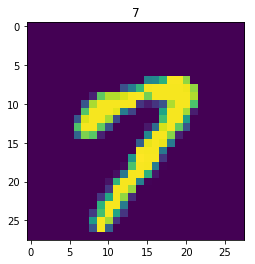

In [0]:
idx = 15
plt.title(train_Y[idx])
plt.imshow(train_X[idx,:,:,0])
plt.show()

### (2) 모델 학습시키기

동일하게 학습되는 것을 확인하실 수 있습니다.

In [0]:
num_epoch = 10
num_batch = 100
num_step = len(train_X)//num_batch

with graph.as_default():

    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())

    for epoch in range(#fix me#):
        for step in tqdm(range(#fix me#)):
            batch_X = train_X[#fix me #]
            batch_Y = train_Y[#fix me #]
            sess.run(#fix me #) # : train 

        acc = sess.run(#fix me #})
        print("[{:2d} epoch] Test 정확도 : {:2.2f}%"
              .format(epoch+1, acc*100))


  1%|          | 4/600 [00:00<00:18, 32.08it/s]

[ 1 epoch] Test 정확도 : 97.16%


  1%|          | 4/600 [00:00<00:17, 35.00it/s]

[ 2 epoch] Test 정확도 : 97.78%


  1%|          | 4/600 [00:00<00:18, 32.64it/s]

[ 3 epoch] Test 정확도 : 98.05%


  1%|          | 4/600 [00:00<00:17, 34.41it/s]

[ 4 epoch] Test 정확도 : 98.18%


  1%|          | 4/600 [00:00<00:16, 35.19it/s]

[ 5 epoch] Test 정확도 : 98.36%


  1%|          | 4/600 [00:00<00:17, 34.67it/s]

[ 6 epoch] Test 정확도 : 98.47%


  1%|          | 4/600 [00:00<00:17, 34.38it/s]

[ 7 epoch] Test 정확도 : 98.75%


  1%|          | 4/600 [00:00<00:17, 34.89it/s]

[ 8 epoch] Test 정확도 : 98.70%


  1%|          | 4/600 [00:00<00:18, 32.34it/s]

[ 9 epoch] Test 정확도 : 98.58%


100%|██████████| 600/600 [00:15<00:00, 38.97it/s]


[10 epoch] Test 정확도 : 98.70%


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/26

---